Copyright (c) Microsoft Corporation. All rights reserved.

Licensed under the MIT License.

# Classifying Commecial Blocks with Microsoft Azure
_**Comparing Automated Machine Learning with three standard Scikit Learn Models.**_

---
---

## Contents
1. [Introduction](#Introduction)
1. [Setup](#Setup)
    1. [Accessing the Azure Workspace](#Accessing-Workspace)
    1. [Importing Libraries](#Importing-Libraries)
    1. [Creating an Experiment](#Creating-an-Experiment)
    1. [Managing Dependencies](#Managing-Dependencies)
1. [Data](#Data)
1. [Classifying with Scikit Learn](#Classifying-with-Scikit-Learn)
1. [Classifying with Automated Machine Learning](#Classifying-with-Automated-Machine-Learning)
1. [Results](#Results)
1. [Test](#Test)

---

## Introduction

**The Task:** Classify commercial blocks from TV news segments (+1 commercial, -1 Non-commercial).

This classification model runs a dataset of broadcast data to classify whether a specific segment is a commercial on television. The dataset was taken from the UCI Machine Learning Repository with over 120,000 instances and 4125 features. For more information about the features in this datset, check out [the UCI Machine Learning Repository](http://archive.ics.uci.edu/ml/datasets/tv+news+channel+commercial+detection+dataset). 

**The Method:** This experiment will compare training a classification model with traditional machine learning models (KNN, Random Forest, Neural Networks) to training it with Microsoft Azure Automated Machine Learning. 

<br>
<img src="https://sportsradiopd.com/wp-content/uploads/2015/11/commercial-e1447279275378.jpg" style="width:500px;">

---

## Setup

This experiment uses [Microsoft Azure Machine Learning Service](https://docs.microsoft.com/en-us/azure/machine-learning/service/) to implement a machine learning classification model. For more examples of Microsoft Machine Learning Service, check out the [Azure Machine Learning Notebooks GitHub Repo](https://github.com/Azure/MachineLearningNotebooks).

### Accessing the Azure Workspace
To configure a Microsoft Azure workspace, you must [set up a  Azure subscription](https://azure.microsoft.com/en-us/free/) and manage the subscription from the [Azure portal](https://portal.azure.com/). Once your workspace is configured in the Azure portal, your machine learning service workspace should look like the following:


<img src="Images/Azure-Configuration.png">

### Configuring the Azure Workspace
Before configuring your workspace, be sure to have the following installed:
```
$ conda install -y matplotlib tqdm scikit-learn
$ pip install azureml-sdk[notebooks,automl]
```
Then, add a `config.json` file in a directory two levels above anything that is being pushed to Github. **Never push your Subscription ID to Github**. Your Azure notebook will find the config file even if it is not in the present directory.

`config.json` should look like the following (see above figure for where to find these inputs):
```
{
    "subscription_id": "<my-subscription-id>",
    "resource_group": "<my-resource-group>",
    "workspace_name": "<my-workspace-name>"
}
```

In [1]:
# Now you're ready to load your workspace...
from azureml.core import Workspace

ws = Workspace.from_config()

Found the config file in: C:\Users\house\Documents\GitHub\config.json


### Import Libraries

In [2]:
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# IMPORT AZURE LIBRARIES
# Azure Notebook Libraries
import azureml.core
import logging
from azureml.core.experiment import Experiment
from azureml.core.workspace import Workspace
from azureml.train.automl import AutoMLConfig

### Creating an Experiment
This command will create a new experiment on Azure's Machine Learning Services Workspace. Experiments track important metrics of each model run, including training time (in seconds) and the ROC curve.

In [4]:
# Choose a name for the experiment and specify the project folder.
experiment_name = 'simple_classification'
project_folder = './simple_classification_project'

experiment = Experiment(ws, experiment_name)

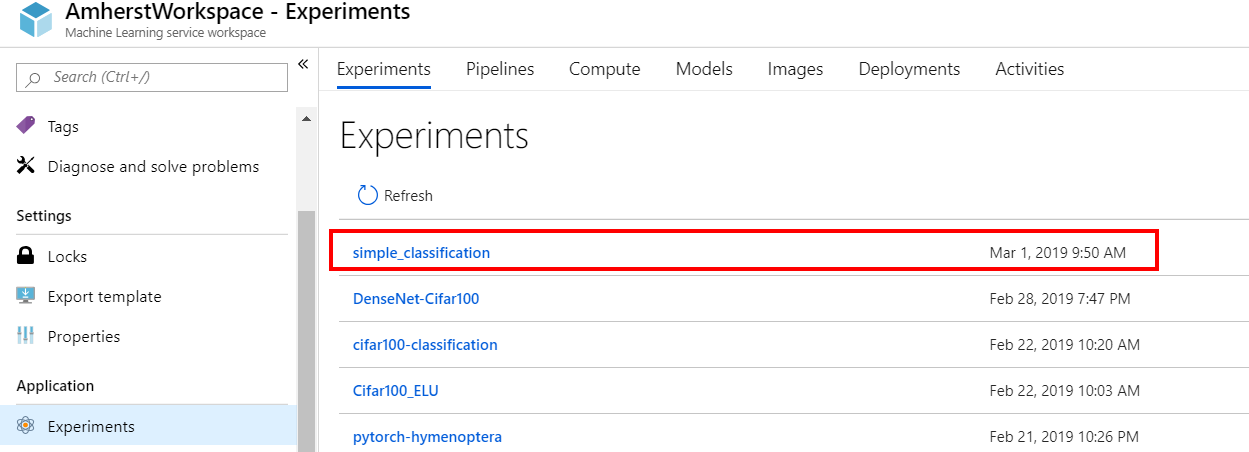

---

## Data
Data is from the UCI Machine Learning Repository with over 120,000 instances and 4125 features to classify commercial blocks.

Data Source:
Dr. Prithwijit Guha , Raghvendra D. Kannao and Ravishankar Soni 
Multimedia Analytics Lab, 
Department of Electrical and Electronics Engineering, 
Indian Institute of Technology, Guwahati, India 
rdkannao '@' gmail.com , prithwijit.guha '@' gmail.com

### Import Data from Local Directory
To import this data, make sure to download the datasets in `Data/` on your local machine and point to your filepath in `get_data()`.

In [5]:
# Data Upload Functions
from sklearn.datasets import load_svmlight_file

def get_data(filepath):
    data = load_svmlight_file(filepath)
    return data[0], data[1]

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# IMPORT DATA
print("\nImporting Data...")

X_train, y_train = get_data("Data/train_data.txt")
X_test, y_test = get_data("Data/test_data.txt")

X_train = X_train.toarray() # convert sparce matrix to array
X_test = X_test.toarray() 
print("Data imported.")


Importing Data...
Data imported.


---

## Classifying with Local `train.py` Script

### Managing Dependencies
This is a local run of the classifcation model, so you must ensure all the necessary packages are available in the Python environment you run in the training script.

In [6]:
from azureml.core.runconfig import RunConfiguration

# Editing a run configuration property on-fly.
run_config_user_managed = RunConfiguration()

run_config_user_managed.environment.python.user_managed_dependencies = True

### Read Local Training Script

In [7]:
with open('./train.py', 'r') as f:
    f.read()

### Run Experiment
Run the local `train.py` script

In [8]:
from azureml.core import ScriptRunConfig

src = ScriptRunConfig(source_directory='./', script='train.py', run_config=run_config_user_managed)
Run = experiment.submit(src)

In [9]:
Run

Experiment,Id,Type,Status,Details Page,Docs Page
simple_classification,simple_classification_1555019240_957cd5fa,azureml.scriptrun,Running,Link to Azure Portal,Link to Documentation


---

## Classifying with Automated Machine Learning

### Configure AML for classification

In [ ]:
automl_config = AutoMLConfig(task = 'classification',
                             debug_log = 'automl_errors.log',
                             primary_metric = 'AUC_weighted',
                             iteration_timeout_minutes = 60,
                             iterations = 5,
                             n_cross_validations = 3,
                             verbosity = logging.INFO,
                             X = X_train, 
                             y = y_train,
                             path = project_folder)

### Run the AML Experiment Locally

In [11]:
local_run = experiment.submit(automl_config, show_output = True)

Running on local machine
Parent Run ID: AutoML_e608e5d1-1895-46d4-b8fa-aac55b8ff649
********************************************************************************************************************
ITERATION: The iteration being evaluated.
PIPELINE: A summary description of the pipeline being evaluated.
SAMPLING %: Percent of the training data to sample.
DURATION: Time taken for the current iteration.
METRIC: The result of computing score on the fitted pipeline.
BEST: The best observed score thus far.
********************************************************************************************************************

 ITERATION   PIPELINE                                       SAMPLING %  DURATION      METRIC      BEST
         0   MaxAbsScaler LightGBM                          100.0000    0:00:28       0.9495    0.9495
         1   RobustScaler LightGBM                          100.0000    0:00:23       0.9719    0.9719
         2   RobustScaler LogisticRegression                100

In [12]:
local_run

Experiment,Id,Type,Status,Details Page,Docs Page
simple_classification,AutoML_e608e5d1-1895-46d4-b8fa-aac55b8ff649,automl,Completed,Link to Azure Portal,Link to Documentation


---

## Results

In [13]:
from azureml.widgets import RunDetails
RunDetails(local_run).show()

_AutoMLWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', 's…

### Select Best Classification Model

In [14]:
best_run, fitted_model = local_run.get_output()
print(best_run)
print(fitted_model)

Run(Experiment: simple_classification,
Id: AutoML_e608e5d1-1895-46d4-b8fa-aac55b8ff649_1,
Type: None,
Status: Completed)
Pipeline(memory=None,
     steps=[('RobustScaler', RobustScaler(copy=True, quantile_range=[25, 75], with_centering=True,
       with_scaling=False)), ('LightGBMClassifier', <automl.client.core.common.model_wrappers.LightGBMClassifier object at 0x0000023897F4E080>)])
Y_transformer(['LabelEncoder', LabelEncoder()])


---

## Test

In [15]:
y_pred = fitted_model.predict(X_test)
y_pred

array([-1.,  1.,  1., ...,  1.,  1., -1.])

In [16]:
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

print('f1 score: %.2f' % f1_score(y_test, y_pred))

f1 score: 0.92
